In [62]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torchtext
import argparse
import os
import pandas as pd
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy,F1Score
from torch.utils.data import DataLoader
from datasets import load_from_disk
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from ray import tune
from ray.train import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

## Classification_model

loading dataset (same cleaning methods and test-train splits with our actual model classification.ipynb files)

In [67]:
dataset = load_from_disk(dataset_path='Dataset/ToS-100-cleaned-dataset-huggingface')
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
#we also need to split the train set into train and validation manually
train, validate = train_test_split(train, test_size=0.5, random_state=42)

some helper function

In [30]:
# covert target into binary matrix
def get_target(y_batch,device):
    target = np.zeros((len(y_batch), 5))
    index = 0
    for y in y_batch:
        target[index][y] = 1
        index += 1
        target = torch.tensor(target).to(torch.float).to(device)
    return target

In [31]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, df):
        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
def my_collate_function(batch, device):
    # Handle the padding here
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

## CNN Model for text classification

In [71]:
def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    glove = torchtext.vocab.GloVe(name="6B",dim=100)

    train_dataset = TextDataset(glove, train)
    val_dataset = TextDataset(glove, validate)

    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

    class CNN(nn.Module):
      def __init__(self, embedding_dim, k1, k2, n1, n2):
          super(CNN, self).__init__()

          self.embedding = nn.Embedding.from_pretrained(glove.vectors)
          self.layer1 = nn.Conv2d(1,n1,kernel_size=(k1,embedding_dim),bias = False)
          self.activition = torch.nn.ReLU()

          self.layer2 = nn.Conv2d(1,n2,kernel_size=(k2,embedding_dim),bias = False)
          self.linear = torch.nn.Linear(in_features=n1+n2,out_features= 5)

      def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)
        x = torch.unsqueeze(x, 1)

        x1 = self.layer1(x)
        x1  = self.activition(x1).squeeze(3)
        x1 = nn.functional.max_pool1d(x1, x1.size(2)).squeeze(2)

        x2 = self.layer2(x)
        x2 = self.activition(x2).squeeze(3)
        x2 = nn.functional.max_pool1d(x2, x2.size(2)).squeeze(2)
        x  = torch.cat((x1,x2),1)

        logits = self.linear(x)

        return logits

    def train_cnn(lr_rate,epochs, k1, k2, n1, n2):
      network = CNN(100, k1, k2, n1, n2).to(device)
      criterion = nn.CrossEntropyLoss().to(device)
      optimizer = torch.optim.Adam(network.parameters(),lr = lr_rate)
      metric = MulticlassAccuracy(num_classes=5).to(device)
      f1 = F1Score(task="multiclass", num_classes=5).to(device)

      trainepoch_loss = []
      valepoch_loss = []
      trainepoch_f1 = []
      trainepoch_accurcy = []
      valepoch_accurcy = []
      valepoch_f1 = []

        # validation dataset
      def evaluation(network):
          valid_loss = []
          valid_accuracy = []
          valid_f1 = []
          for i, (X_batch, y_batch) in enumerate(validation_dataloader):
            X_batch.to(device)
            target = get_target(y_batch,device)
            output = network(X_batch)
            loss_val = criterion(output,target.squeeze(1))
            # loss and accuracy
            probs = torch.sigmoid(output)
            valid_accuracy.append(metric(probs, target).item())
            valid_f1.append(f1(probs, target).item())
            valid_loss.append(loss_val.item())
          return valid_accuracy,valid_loss,valid_f1

      for epoch in range(epochs):
          train_loss = []
          train_accuracy = []
          train_f1 = []

          for i, (X_batch, y_batch) in enumerate(train_dataloader):
            target = get_target(y_batch,device)


            optimizer.zero_grad()

            output = network(X_batch)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()

            # loss and accuracy
            train_loss.append(loss.item())

            probs = torch.sigmoid(output)
            train_accuracy.append(metric(probs, target).item())
            train_f1.append(f1(probs, target).item())

          # running evaluation function once per two epoch
          if (epoch % 2 == 0):
            valid_accuracy,valid_loss,valid_f1 = evaluation(network)


          print(f'\t\t ------- Epoch {epoch+1} ---------')
          print(f'\t\t Training Loss: {np.mean(train_loss)} \t\t Training Accurcy: {np.mean(train_accuracy)} \t\t Training F1: {np.mean(train_f1)}')
          print(f'\t\t Validation Loss: {np.mean(valid_loss)} \t\t Validation Accurcy: {np.mean(valid_accuracy)} \t\t Validation F1: {np.mean(valid_f1)}')

          trainepoch_loss.append(np.mean(train_loss))
          valepoch_loss.append(np.mean(valid_loss))

          trainepoch_f1.append(np.mean(train_f1))
          valepoch_f1.append(np.mean(valid_f1))

          trainepoch_accurcy.append(np.mean(train_accuracy))
          valepoch_accurcy.append(np.mean(valid_accuracy))

      return trainepoch_loss,trainepoch_accurcy,valepoch_loss,valepoch_accurcy,trainepoch_f1,valepoch_f1,network

    trainepoch_loss,trainepoch_accurcy,valepoch_loss,valepoch_accurcy,trainepoch_f1,valepoch_f1,network = train_cnn(0.003,300,args.k1,args.k2,args.n1,args.n2)
    return trainepoch_loss,trainepoch_accurcy,valepoch_loss,valepoch_accurcy,trainepoch_f1,valepoch_f1,network

grid search for different hyperparameter

In [72]:
np.random.seed(43)
torch.manual_seed(43)

# test through different combinations and below are the best hyperparameters
batch_size = [10]
k = [[2,4]]
n = [60]

#through each hyperparameter
for batch in batch_size:
  for k1,k2 in k:
    for n_size in n:
      print('===' + str(batch) + '===' + str(k1) + '===' + str(k2) + '===' + str(n_size))
      trainepoch_loss,trainepoch_accurcy,\
      valepoch_loss,valepoch_accurcy,trainepoch_f1,\
      valepoch_f1,network = main(args=argparse.Namespace(batch_size=batch,
                                                         overfit = False,k1 = k1,
                                                         k2 = k2,n1=n_size,n2=n_size))

===10===2===4===60
Using device: cpu
		 ------- Epoch 1 ---------
		 Training Loss: 0.45782936528718293 		 Training Accurcy: 0.5 		 Training F1: 0.0
		 Validation Loss: 0.24209287830560153 		 Validation Accurcy: 0.5 		 Validation F1: 0.0
		 ------- Epoch 2 ---------
		 Training Loss: 0.20955049671166315 		 Training Accurcy: 0.5 		 Training F1: 0.0
		 Validation Loss: 0.24209287830560153 		 Validation Accurcy: 0.5 		 Validation F1: 0.0
		 ------- Epoch 3 ---------
		 Training Loss: 0.14105636885603845 		 Training Accurcy: 0.5012679920775013 		 Training F1: 0.0005071966987386642
		 Validation Loss: 0.2057929010642086 		 Validation Accurcy: 0.5006854011229737 		 Validation F1: 0.00027416037769657526
		 ------- Epoch 4 ---------
		 Training Loss: 0.11106953005056037 		 Training Accurcy: 0.5070339288917447 		 Training F1: 0.0028135708767494326
		 Validation Loss: 0.2057929010642086 		 Validation Accurcy: 0.5006854011229737 		 Validation F1: 0.00027416037769657526
		 ------- Epoch 5 --------

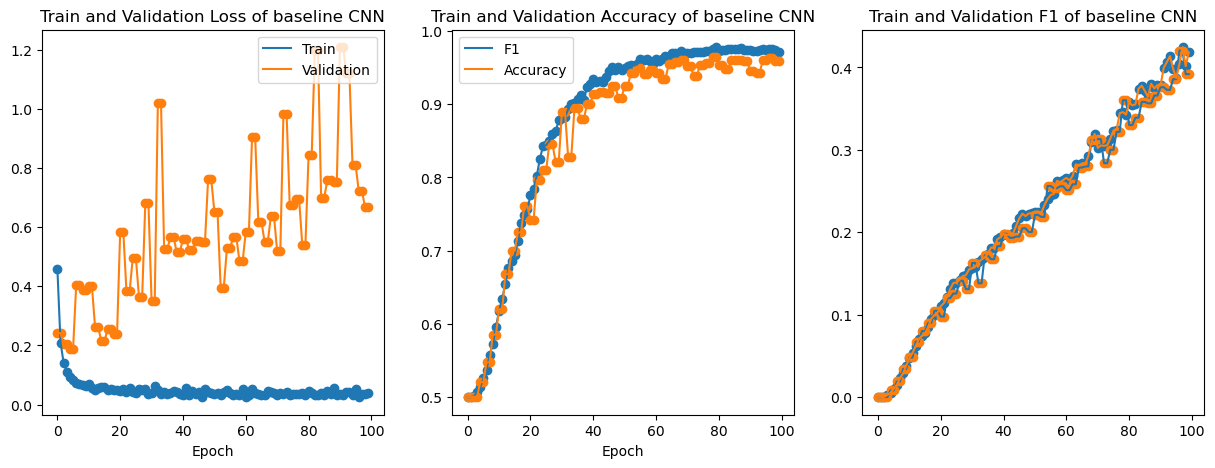

In [74]:
#subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(trainepoch_loss)
axs[0].plot(valepoch_loss)
axs[0].scatter(range(0,len(trainepoch_loss)),trainepoch_loss)
axs[0].scatter(range(0,len(valepoch_loss)),valepoch_loss)
axs[0].set_title('Train and Validation Loss of baseline CNN')
axs[0].set_label('Loss')
axs[0].set_xlabel('Epoch')
#legend
axs[0].legend(['Train', 'Validation'], loc='upper right')

axs[1].plot(trainepoch_accurcy)
axs[1].plot(valepoch_accurcy)
axs[1].scatter(range(0,len(trainepoch_accurcy)),trainepoch_accurcy)
axs[1].scatter(range(0,len(valepoch_accurcy)),valepoch_accurcy)
axs[1].set_title('Train and Validation Accuracy of baseline CNN')
axs[1].set_label('F1 and Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['F1', 'Accuracy'], loc='best')

axs[2].plot(valepoch_f1)
axs[2].plot(trainepoch_f1)
axs[2].scatter(range(0,len(trainepoch_f1)),trainepoch_f1)
axs[2].scatter(range(0,len(valepoch_f1)),valepoch_f1)
axs[2].set_title('Train and Validation F1 of baseline CNN')


#save as svg
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.savefig('plot/cnn_loss_f1_accuracy.svg', format='svg', dpi=1200)

test set using f1 and accuracy

In [75]:
test_accuracy = []
test_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metric = MulticlassAccuracy(num_classes=5).to(device)
f1 = F1Score(task="multiclass", num_classes=5).to(device)

glove = torchtext.vocab.GloVe(name="6B",dim=100)

test_dataset = TextDataset(glove, test)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,batch_size=5,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))


for i, (X_batch, y_batch) in enumerate(test_dataloader):
  target = get_target(y_batch,device)
  X_batch.to(device)
  output = network(X_batch)
  probs = torch.sigmoid(output)
  test_accuracy.append(metric(probs, target).item())
  test_f1.append(f1(probs, target).item())
  
print('the final test accuracy is: ' + str(np.mean(test_accuracy)))
print('the final test f1 is: ' + str(np.mean(test_f1)))

the final test accuracy is: 0.955234756487702
the final test f1 is: 0.444914323947379
